In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [5]:
original_data = pd.read_csv('../../Data/rnn_data.csv',low_memory=False)
original_data = original_data.groupby('contractSymbol').filter(lambda x: x['Date'].nunique() == 6).sort_values(by = ["contractSymbol","Date"])
original_data.drop("Ticker", axis = 1,inplace = True)

In [6]:
call_data = original_data[original_data["Call"] == 1]
put_data = original_data[original_data["Call"] == 0]

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

data = call_data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.fillna(method='ffill', inplace=True)

features_to_scale = ['strike', 'Underlying Price', 'Annualized Volatility', 'lastPrice', 'Expiration']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

def create_sequences(data, window_size=6):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][features_to_scale].values
        target = data.iloc[i + window_size]['lastPrice']
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

X, y = create_sequences(data)

C:\Users\Domenico\AppData\Local\Temp\ipykernel_16124\2615073960.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
C:\Users\Domenico\AppData\Local\Temp\ipykernel_16124\2615073960.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [19]:
del RNN_call

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Adding EarlyStopping and LearningRateScheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Building a more robust model
RNN_call = Sequential()
RNN_call.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
RNN_call.add(Dropout(0.01))
RNN_call.add(LSTM(128, return_sequences=False))
RNN_call.add(Dropout(0.01))
RNN_call.add(Dense(182, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
RNN_call.add(Dense(1))

RNN_call.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
RNN_call.summary()

# Train the model
history = RNN_call.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 6, 128)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 182)            │        23,478 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,853 (874.43 KB)

 Trainable params: 223,853 (874.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - loss: 0.0382 - mae: 0.0155 - val_loss: 5.5206e-04 - val_mae: 0.0096 - learning_rate: 0.0010
Epoch 2/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.0011 - mae: 0.0149 - val_loss: 5.5000e-04 - val_mae: 0.0130 - learning_rate: 0.0010
Epoch 3/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - loss: 0.0011 - mae: 0.0149 - val_loss: 5.3992e-04 - val_mae: 0.0107 - learning_rate: 0.0010
Epoch 4/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.0011 - mae: 0.0147 - val_loss: 5.1046e-04 - val_mae: 0.0114 - learning_rate: 0.0010
Epoch 5/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.0011 - mae: 0.0147 - val_loss: 4.8448e-04 - val_mae: 0.0112 - learning_rate: 0.0010
Epoch 6/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.0010 - mae: 0.0147 - val_loss: 4.8958e-04 - val_mae: 0.0114 - learning_rate: 0.0010
Epoch 7/50
9954/9954 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.0010 - mae: 0.0145 - val_loss: 5.2201e-04

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Squared Error (MSE): 71605.6433
Root Mean Squared Error (RMSE): 267.5923
Mean Absolute Error (MAE): 267.5923
Mean Absolute Percentage Error (MAPE): 453.55%
R-squared (R^2): nan


c:\Users\Domenico\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


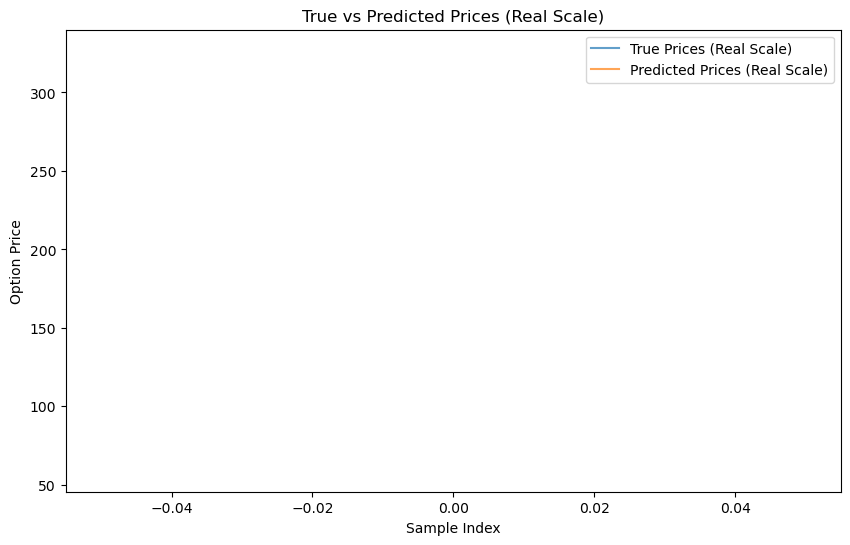

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

shuffled_indices = np.random.permutation(len(X))
test_size = int(0.000002 * len(X))
test_indices = shuffled_indices[:test_size]

X_random_test = X[test_indices]
y_random_test = y[test_indices]


y_random_pred_scaled = RNN_call.predict(X_random_test)

temp_pred = np.zeros((len(y_random_pred_scaled), len(features_to_scale)))
temp_pred[:, features_to_scale.index('lastPrice')] = y_random_pred_scaled.flatten()

temp_test = np.zeros((len(y_random_test), len(features_to_scale)))
temp_test[:, features_to_scale.index('lastPrice')] = y_random_test.flatten()

y_random_pred_real = scaler.inverse_transform(temp_pred)[:, features_to_scale.index('lastPrice')]
y_random_test_real = scaler.inverse_transform(temp_test)[:, features_to_scale.index('lastPrice')]

mse_real = mean_squared_error(y_random_test_real, y_random_pred_real)
rmse_real = np.sqrt(mse_real)
mae_real = mean_absolute_error(y_random_test_real, y_random_pred_real)
mape_real = np.mean(np.abs((y_random_test_real - y_random_pred_real) / y_random_test_real)) * 100
r2_real = r2_score(y_random_test_real, y_random_pred_real)

print(f"Mean Squared Error (MSE): {mse_real:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_real:.4f}")
print(f"Mean Absolute Error (MAE): {mae_real:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_real:.2f}%")
print(f"R-squared (R^2): {r2_real:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_random_test_real, label='True Prices (Real Scale)', alpha=0.7)
plt.plot(y_random_pred_real, label='Predicted Prices (Real Scale)', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Prices (Real Scale)')
plt.xlabel('Sample Index')
plt.ylabel('Option Price')
plt.show()


In [11]:
y_random_pred_real

array([52.92658521, 22.71954543, 60.48144216, ..., 34.47622989,
       40.71252127, 30.78166001])

In [16]:

# Rescaling the predictions and true values back to their original scale
lastPrice_scaler = MinMaxScaler()
lastPrice_scaler.fit(data[['lastPrice']])

y_pred_rescaled = lastPrice_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = lastPrice_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics Calculation
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Printing the results
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')

MAE: 0.009927501519854469
MSE: 0.0004496704356190568
RMSE: 0.02120543410588561
MAPE: 586619915543.5624
R²: 0.6115395829034527


In [17]:
data = put_data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.fillna(method='ffill', inplace=True)

features_to_scale = ['strike', 'Underlying Price', 'Annualized Volatility', 'lastPrice', 'Expiration']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

def create_sequences(data, window_size=6):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][features_to_scale].values
        target = data.iloc[i + window_size]['lastPrice']
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

X, y = create_sequences(data)

KeyboardInterrupt: 

c:\Users\Domenico\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
17255/17255 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 2/5
17255/17255 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 9.9913e-04 - val_loss: 9.8266e-04
Epoch 3/5
17255/17255 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 9.9649e-04 - val_loss: 9.7509e-04
Epoch 4/5
17255/17255 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 9.9858e-04 - val_loss: 9.8389e-04
Epoch 5/5
17255/17255 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 9.7673e-04 - val_loss: 9.8537e-04
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.2615e-04
Test Loss: 0.0009853736264631152
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


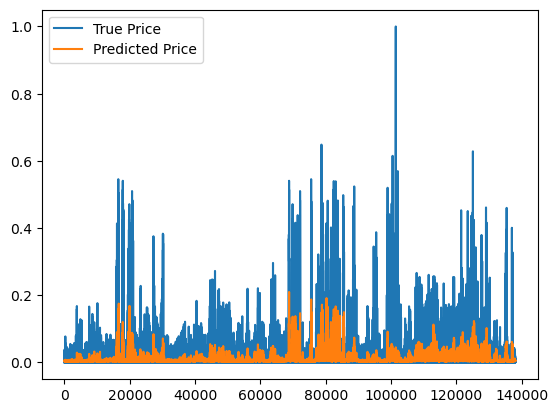

In [ ]:
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

RNN_put = Sequential()
RNN_put.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
RNN_put.add(Dropout(0.2))  # Dropout layer to prevent overfitting
RNN_put.add(Dense(32, activation='relu'))  # Fully connected layer
RNN_put.add(Dense(1))  # Output layer

RNN_put.compile(optimizer='adam', loss='mean_squared_error')
RNN_put.summary()
history = RNN_put.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

test_loss = RNN_put.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

y_pred = RNN_put.predict(X_test)

plt.plot(y_test, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.legend()
plt.show()

In [ ]:
# Rescaling the predictions and true values back to their original scale
lastPrice_scaler = MinMaxScaler()
lastPrice_scaler.fit(data[['lastPrice']])

y_pred_rescaled = lastPrice_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = lastPrice_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics Calculation
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Printing the results
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R²: {r2}')

MAE: 0.01178787698282873
MSE: 0.000985374336405338
RMSE: 0.031390672761273185
MAPE: 788589495179.1934
R²: 0.1257632646959974


In [12]:
RNN_call.save('models\\rnn\RNN_call.keras', save_format='keras')
RNN_put.save('models\\rnn\RNN_put.keras', save_format='keras')